### Step 1: Import library

In [2]:
import importlib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


import utils
importlib.reload(utils) 

<module 'utils' from '/Users/mac/Desktop/kingston/Deep-learning-assignment/utils.py'>

### Step 2: Import training data

In [3]:
df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.sort_values(by="Date", inplace=True)
# df.set_index('Date', inplace=True)

### Step 3: Preprocessing the data


In [4]:

# Feature Engineering
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.weekday
df["Open_Lag1"] = df["Open"].shift(1)
df["Open_Lag2"] = df["Open"].shift(2)
df["MA3"] = df["Open"].rolling(window=3).mean()
df["MA5"] = df["Open"].rolling(window=5).mean()
df.dropna(inplace=True)

# Select features and target
features = ["Time", "Year", "Month", "Day", "Weekday", "Open_Lag1", "Open_Lag2", "MA3", "MA5"]
target = "Open"

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

### Step 3: Separate the data to Train, Validation & Test 

In [5]:
# Create sequences for LSTM
sequence_length = 60
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

X, y = df[features].values, df[target].values
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

### Step 5: Hyper parameter tuning 

In [6]:

# Define LSTM-CNN Model with hyper-tuning for the number of layers
def build_lstm_cnn_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    # Hyper-tuning number of CNN layers (added before LSTM)
    for i in range(hp.Int('num_cnn_layers', 1, 5)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'cnn_filters_{i}', min_value=16, max_value=256, step=32),
            kernel_size=hp.Choice(f'cnn_kernel_size_{i}', values=[1, 2]),
            activation='relu'
        ))
    
    # Hyper-tuning number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 5)):
        model.add(layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32),
            return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False
        ))
    
    model.add(layers.Flatten())
    
    # Hyper-tuning number of Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
    
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_lstm_cnn_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband_tuning',
    project_name='lstm_cnn_forex'
)

# Run Hyperband tuning
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)



Reloading Tuner from hyperband_tuning/lstm_cnn_forex/tuner0.json
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.1094 - mae: 0.2531 - val_loss: 0.0121 - val_mae: 0.1034
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0154 - mae: 0.0966 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0105 - mae: 0.0810 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0108 - mae: 0.0823 - val_loss: 0.0011 - val_mae: 0.0272
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0096 - mae: 0.0783 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0098 - mae: 0.0765 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0089 - mae: 0.0738 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0082 - mae: 0.0707 - val_loss: 0.0011 - val_mae

### Step 6: Best Parameters

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Test MAE: 0.01912022643746531
Test MSE: 0.0006955807842981369
Test R2 Score: 0.8549087700330431
Test MAPE: 12.058042131892293


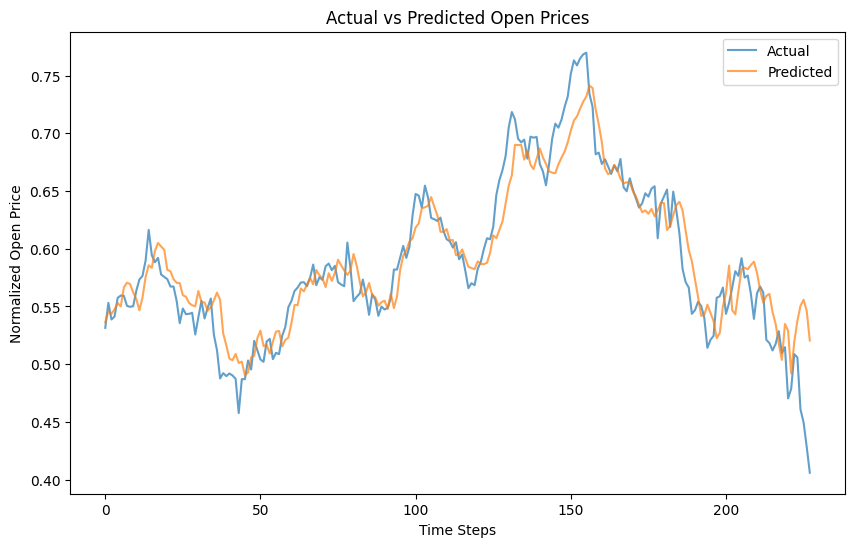

In [7]:

# Evaluate on test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test R2 Score: {r2}")
print(f"Test MAPE: {mape}")

# Plot y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Normalized Open Price')
plt.legend()
plt.title('Actual vs Predicted Open Prices')
plt.show()

### Step 1: Import library

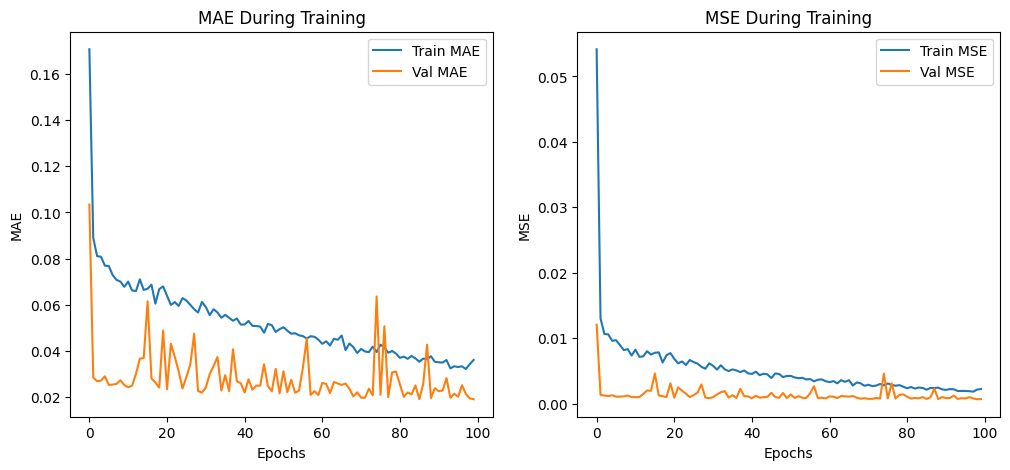

In [8]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE During Training')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE During Training')

plt.show()